# Collecting data from the Strava API

### Initial setup

In [20]:
from dotenv import load_dotenv
import os

import requests
from datetime import datetime 
import polyline
import stravalib
import pandas as pd
import folium

### Loading tokens

In [2]:
# Load the .env file
load_dotenv()

# Now you can access your tokens
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
REFRESH_TOKEN = os.getenv("REFRESH_TOKEN")

### Collecting data through the API

In [3]:
# Base URL for the Strava API
BASE_URL = 'https://www.strava.com/api/v3'

# Authentication
def authenticate():
    # Step 1: Generate an authorization URL
    auth_url = f'https://www.strava.com/oauth/authorize?client_id={CLIENT_ID}&redirect_uri=http://localhost&response_type=code&scope=read_all,activity:read_all'
    print(f'Please visit the following URL to authorize the application:\n{auth_url}')

    # Step 2: Obtain the authorization code
    auth_code = input('Enter the authorization code from the URL: ')

    # Step 3: Exchange authorization code for access token
    data = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'code': auth_code,
        'grant_type': 'authorization_code'
    }
    response = requests.post('https://www.strava.com/oauth/token', data=data)
    access_token = response.json().get('access_token')

    return access_token

# Make a request to the Strava API
def make_request(endpoint, method='GET', params=None, data=None, headers=None):
    url = BASE_URL + endpoint
    headers = headers or {}
    headers['Authorization'] = f'Bearer {ACCESS_TOKEN}'

    response = requests.request(method, url, params=params, data=data, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f'Request failed with status code {response.status_code}:\n{response.text}')

# Get activities
def get_activities():
    return make_request('/athlete/activities')

# Authentication to obtain an access token
ACCESS_TOKEN = authenticate()

activities = get_activities()

Please visit the following URL to authorize the application:
https://www.strava.com/oauth/authorize?client_id=108076&redirect_uri=http://localhost&response_type=code&scope=read_all,activity:read_all
Enter the authorization code from the URL: e406ddbf7120066afe2245ba0b6dad9210721264


### Examining my list of activities on Strava

In [4]:
for activity in activities:
    print(f"Date: {activity['start_date_local'].split('T')[0]}, Name: {activity['name']}")

Date: 2023-05-27, Name: Pre breakfast jog
Date: 2023-05-23, Name: Evening jog
Date: 2023-05-22, Name: Evening weighted walk
Date: 2023-05-21, Name: Evening jog 
Date: 2023-05-19, Name: Afternoon jog
Date: 2022-10-03, Name: Morning Hike
Date: 2022-09-27, Name: Evening Hike
Date: 2022-09-21, Name: Evening Hike
Date: 2022-05-24, Name: Evening Run
Date: 2022-05-18, Name: Evening Run
Date: 2022-05-15, Name: Afternoon Hike
Date: 2022-05-14, Name: Afternoon Hike
Date: 2022-05-11, Name: Evening Run
Date: 2022-04-30, Name: Morning Run
Date: 2022-04-20, Name: Evening Run
Date: 2022-04-08, Name: Afternoon Walk
Date: 2022-03-29, Name: Disc Golf at Morley’s 


### Examining the available data

In [5]:
activities[0]

{'resource_state': 2,
 'athlete': {'id': 100848450, 'resource_state': 1},
 'name': 'Pre breakfast jog',
 'distance': 6657.0,
 'moving_time': 2415,
 'elapsed_time': 2455,
 'total_elevation_gain': 14.0,
 'type': 'Run',
 'sport_type': 'Run',
 'workout_type': 3,
 'id': 9149015574,
 'start_date': '2023-05-27T10:01:40Z',
 'start_date_local': '2023-05-27T11:01:40Z',
 'timezone': '(GMT+00:00) Europe/London',
 'utc_offset': 3600.0,
 'location_city': None,
 'location_state': None,
 'location_country': None,
 'achievement_count': 14,
 'kudos_count': 0,
 'comment_count': 0,
 'athlete_count': 1,
 'photo_count': 0,
 'map': {'id': 'a9149015574',
  'summary_polyline': 'cjnyHr~_@I]SYMe@SCJOKO?K@QNYT{@d@}@?KOe@KMm@oCGUIIYiAGSG[AUWiAEm@QqAEu@OyAAYG[Eq@Kq@KyAY{@?]IqAEC[Za@|@KFM@GDE?MPE@Qr@U\\[t@G@Q]a@a@Kq@MOEOMOICE?EGK[OW@KEi@`@_A\\i@Pg@Zo@|@_BRQJUVUBILGJOZSNOf@WRUZSHKHEJOr@a@d@m@T_@Xw@P}@z@oBZqAl@oBP}@Pk@Hg@BWUoC_@cD?YMmAKe@?YGk@Os@OaBCs@IYEw@K_@A]K]O_CIa@Cu@Ik@MgBK_@Ae@Iu@E{@e@mEWwCOeAKYCEEAQ?]FQCSBw@GO

In [6]:
# Choosing some fields of interest from the data

my_cols =['name',
          'start_date_local',
          'type',
          'distance', # Unit: meters
          'moving_time', # Unit: seconds
          'elapsed_time', # Unit: seconds
          'total_elevation_gain', # Unit: meters
          'elev_high', # Unit: meters
          'elev_low', # Unit: meters
          'average_speed',
          'max_speed'
         ]

### Collect together the relevant data into a list

In [7]:
exercise_data = []
map_data = []

for activity in activities[0:5]:
    exercise_data.append([activity['id']]+[activity.get(x) for x in my_cols])
    # summary_polyline is encoded map data
    map_data.append(activity['map']['summary_polyline'])
    
# Adding id to the beginning of the columns (used later when creating dataframe)
my_cols.insert(0,'id')

### Examining the exercise data

In [8]:
exercise_data

[[9149015574,
  'Pre breakfast jog',
  '2023-05-27T11:01:40Z',
  'Run',
  6657.0,
  2415,
  2455,
  14.0,
  37.7,
  28.9,
  2.757,
  5.448],
 [9126742532,
  'Evening jog',
  '2023-05-23T18:46:44Z',
  'Run',
  6651.7,
  2415,
  2434,
  14.0,
  37.7,
  28.9,
  2.754,
  5.758],
 [9120779080,
  'Evening weighted walk',
  '2023-05-22T18:22:02Z',
  'Walk',
  5921.0,
  3947,
  4076,
  13.6,
  37.7,
  28.9,
  1.5,
  2.974],
 [9115333522,
  'Evening jog ',
  '2023-05-21T19:02:24Z',
  'Run',
  6644.5,
  2694,
  2737,
  14.0,
  37.7,
  28.9,
  2.466,
  5.162],
 [9101137827,
  'Afternoon jog',
  '2023-05-19T16:33:02Z',
  'Run',
  6753.7,
  2808,
  2874,
  14.0,
  37.7,
  28.9,
  2.405,
  4.468]]

### Examining the encoded map data

In [9]:
map_data

['cjnyHr~_@I]SYMe@SCJOKO?K@QNYT{@d@}@?KOe@KMm@oCGUIIYiAGSG[AUWiAEm@QqAEu@OyAAYG[Eq@Kq@KyAY{@?]IqAEC[Za@|@KFM@GDE?MPE@Qr@U\\[t@G@Q]a@a@Kq@MOEOMOICE?EGK[OW@KEi@`@_A\\i@Pg@Zo@|@_BRQJUVUBILGJOZSNOf@WRUZSHKHEJOr@a@d@m@T_@Xw@P}@z@oBZqAl@oBP}@Pk@Hg@BWUoC_@cD?YMmAKe@?YGk@Os@OaBCs@IYEw@K_@A]K]O_CIa@Cu@Ik@MgBK_@Ae@Iu@E{@e@mEWwCOeAKYCEEAQ?]FQCSBw@GOB]Ag@EQ@KB[?QB{@Bw@?QAg@DoA@k@D]Eo@DGAQDG?KG[A_@FcA@QAc@?[DS?OBcA^w@\\M@SJ[Fg@RI?QLkA^q@\\w@RWJQBYFu@VIFc@NI?e@V_APWHsBx@m@PIFSD]POBEFI?WJKBq@b@QTq@fA[~@YnAIj@ITEd@KZW`CEVE~@B`BHp@?ZDPDd@AZFPRrA@\\FZFx@Pt@GnA@NFRDd@\\lCb@bCDh@Lh@Fh@`@tBPtANj@RnBnAtG`@lCRx@HbAPt@@PJd@Dh@ZfAHl@FHNBXj@PRx@n@XXDB`@^RJ\\^r@p@XLNMJ@b@\\`@RHNFDF@\\`@t@n@VPL@NHZHbADLKRCLI`@KRCTMd@MNILED@LKZK\\i@NMZg@j@q@DOFCN_@LSBADDFAVMDMZg@Z_@\\w@v@oA\\c@N[H[DGRP^n@r@t@Zr@BNT\\?DFAHJDAFD?ADD@C@@?AN?HWFI?WNUXeARc@\\iAVUBH?LD`@ALn@|CDd@AZPt@Bv@n@dFBt@PnAL^?VPj@JPHVHLFNPZDBVx@^`A?ZEVAf@EBGROPGLKJMVSX@VFLDFVJJRFDJX',
 'wjnyHd~_@QWO_@Kq@\\UDQPOFQNMJc@?mAMe@Q]Oq@IK[{AOSQ{@OWKe@Ce@Oy@WoBImAScB[}AK[

### Decoding map data

In [10]:
decoded_map_data = []

for route in map_data:
    decoded_route = polyline.decode(route,5)
    decoded_map_data.append(decoded_route)

decoded_map_data

[[(51.52434, -0.1689),
  (51.52439, -0.16875),
  (51.52449, -0.16862),
  (51.52456, -0.16843),
  (51.52466, -0.16841),
  (51.5246, -0.16833),
  (51.52466, -0.16825),
  (51.52466, -0.16819),
  (51.52465, -0.1681),
  (51.52457, -0.16797),
  (51.52446, -0.16767),
  (51.52427, -0.16736),
  (51.52427, -0.1673),
  (51.52435, -0.16711),
  (51.52441, -0.16704),
  (51.52464, -0.16632),
  (51.52468, -0.16621),
  (51.52473, -0.16616),
  (51.52486, -0.16579),
  (51.5249, -0.16569),
  (51.52494, -0.16555),
  (51.52495, -0.16544),
  (51.52507, -0.16507),
  (51.5251, -0.16484),
  (51.52519, -0.16443),
  (51.52522, -0.16416),
  (51.5253, -0.16371),
  (51.52531, -0.16358),
  (51.52535, -0.16344),
  (51.52538, -0.16319),
  (51.52544, -0.16294),
  (51.5255, -0.16249),
  (51.52563, -0.16219),
  (51.52563, -0.16204),
  (51.52568, -0.16163),
  (51.52571, -0.16161),
  (51.52585, -0.16175),
  (51.52602, -0.16206),
  (51.52608, -0.1621),
  (51.52615, -0.16211),
  (51.52619, -0.16214),
  (51.52622, -0.16214),
 

### Creating a dataframe

In [11]:
# Remove weighted walk for consistency
exercise_data.pop(2)

# Create a strava dataframe
strava_df = pd.DataFrame(exercise_data, columns=my_cols)

# Convert distances to kilometers
strava_df['distance_km'] = strava_df['distance']/1000

# Convert dates to datetime type
strava_df['start_date_local'] = pd.to_datetime(strava_df['start_date_local'])

strava_df['start_date'] = strava_df['start_date_local'].dt.date
strava_df['start_time'] = strava_df['start_date_local'].dt.time

# Convert times to minutes
strava_df['elapsed_time_min'] = strava_df['elapsed_time']/60
strava_df['moving_time_min'] = strava_df['moving_time']/60

In [12]:
strava_df.head()

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,distance_km,start_date,start_time,elapsed_time_min,moving_time_min
0,9149015574,Pre breakfast jog,2023-05-27 11:01:40+00:00,Run,6657.0,2415,2455,14.0,37.7,28.9,2.757,5.448,6.6570,2023-05-27,11:01:40,40.916667,40.25
1,9126742532,Evening jog,2023-05-23 18:46:44+00:00,Run,6651.7,2415,2434,14.0,37.7,28.9,2.754,5.758,6.6517,2023-05-23,18:46:44,40.566667,40.25
2,9115333522,Evening jog,2023-05-21 19:02:24+00:00,Run,6644.5,2694,2737,14.0,37.7,28.9,2.466,5.162,6.6445,2023-05-21,19:02:24,45.616667,44.90
3,9101137827,Afternoon jog,2023-05-19 16:33:02+00:00,Run,6753.7,2808,2874,14.0,37.7,28.9,2.405,4.468,6.7537,2023-05-19,16:33:02,47.900000,46.80


In [13]:
strava_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    4 non-null      int64              
 1   name                  4 non-null      object             
 2   start_date_local      4 non-null      datetime64[ns, UTC]
 3   type                  4 non-null      object             
 4   distance              4 non-null      float64            
 5   moving_time           4 non-null      int64              
 6   elapsed_time          4 non-null      int64              
 7   total_elevation_gain  4 non-null      float64            
 8   elev_high             4 non-null      float64            
 9   elev_low              4 non-null      float64            
 10  average_speed         4 non-null      float64            
 11  max_speed             4 non-null      float64            
 12  distance_km 

### Mapping out the route using decoded data with Folium

In [14]:
route = decoded_map_data[0]

# Initialize a map centered around the average coordinates
avg_lat = sum(coord[0] for coord in route) / len(route)
avg_lon = sum(coord[1] for coord in route) / len(route)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)

# Create the PolyLine object
folium.PolyLine(route, color="blue", weight=2.5, opacity=1).add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)

# Display the map
m

### Using the stravalib module to get segment data

In [18]:
import stravalib

# Initialize Strava client with ACCESS_TOKEN above
client = stravalib.Client(access_token=ACCESS_TOKEN)

activity_list = list(strava_df['id'])

for activity_id in [activity_list[0]]:

    # Retrieve the activity
    activity = client.get_activity(activity_id)

    # Retrieve segment efforts from the activity
    segment_efforts = activity.segment_efforts
    
    print(activity.start_date_local)
    print(len(segment_efforts))

    # Iterate over segment efforts and print segment information
    for effort in segment_efforts:
        segment = effort.segment
        print(f"Segment ID: {segment.id}")
        print(f"Segment Name: {segment.name}")
        print(f"Segment Distance: {segment.distance}")
        print(f"Segment Average Grade: {segment.average_grade}")
        print(f"Segment Elapsed Time (in seconds): {effort.elapsed_time.seconds}")
        print(f"Segment Average speed (m/s): {float(segment.distance/effort.elapsed_time.seconds):.3f}")
        
        # Make a request to get segment details
        url = f"https://www.strava.com/api/v3/segments/{segment.id}"
        headers = {
            "Authorization": f"Bearer {ACCESS_TOKEN}"
        }
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            segment_data = response.json()
            encoded_path = segment_data.get('map', {}).get('polyline')

            if polyline:
                print(f"Segment Polyline: {encoded_path}")
        else:
            print(f"Error retrieving segment details: {response.status_code}, {response.text}")

        print("---")


2023-05-27 11:01:40
13
Segment ID: 25716255
Segment Name: Bobby's kick home
Segment Distance: 500.7 meter
Segment Average Grade: -0.8
Segment Elapsed Time (in seconds): 148
Segment Average speed (m/s): 3.383
Segment Polyline: ginyHnv_@?OGY_@eAg@iA_@yAa@mCI]QaBYaBC[GiCk@kDCkA[iAQcA@y@L]@BL?
---
Segment ID: 7557239
Segment Name: RP inside perimeter - Baker street to York Bridge
Segment Distance: 395.7 meter
Segment Average Grade: 0.1
Segment Elapsed Time (in seconds): 145
Segment Average speed (m/s): 2.729
Segment Polyline: wlnyHv{]KIIMGWBOf@mAPWLa@PYTs@LiAHuAZ{D?{ADe@Go@ISO{@A]OkB
---
Segment ID: 7557248
Segment Name: RP Inside perimeter - York Bridge to Regent's Park Tube
Segment Distance: 315.5 meter
Segment Average Grade: -0.1
Segment Elapsed Time (in seconds): 114
Segment Average speed (m/s): 2.768
Segment Polyline: }inyHzz\CmAOkBC}AM}@Eu@Gu@?g@]iAKcACm@@m@OeC?S
---
Segment ID: 1155523
Segment Name: Outer Circle segment
Segment Distance: 1415.72 meter
Segment Average Grade: 0.8
Segm

### Attempting to colour segments by pace

In [16]:
def get_color(pace):
    if pace < 2.65:
        return "green"
    elif pace < 2.75:
        return "yellow"
    else:
        return "red"
    
# Experimented with values here (need more principled approach...)

### Most recent jog colour coded by segment

In [22]:
client = stravalib.Client(access_token=ACCESS_TOKEN)

# Initialize a map centered around the average coordinates
avg_lat = sum(coord[0] for coord in decoded_map_data[0]) / len(decoded_map_data[0])
avg_lon = sum(coord[1] for coord in decoded_map_data[0]) / len(decoded_map_data[0])

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)

activity_list = list(strava_df['id'])

for activity_id in [activity_list[0]]:

    # Retrieve the activity
    activity = client.get_activity(activity_id)
    
    folium.PolyLine(decoded_map_data[0], color='white', weight=1.5, opacity=0.5).add_to(m)

    # Retrieve segment efforts from the activity
    segment_efforts = activity.segment_efforts

    # Iterate over segment efforts and print segment information
    for effort in segment_efforts:
        segment = effort.segment
        pace = float(segment.distance/effort.elapsed_time.seconds)
        
        # Make a request to get segment details
        url = f"https://www.strava.com/api/v3/segments/{segment.id}"
        headers = {
            "Authorization": f"Bearer {ACCESS_TOKEN}"
        }
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            segment_data = response.json()
            encoded_path = segment_data.get('map', {}).get('polyline')

            if encoded_path:
                path = polyline.decode(encoded_path,5)
                folium.PolyLine(path, color=get_color(pace), weight=2.5, opacity=1).add_to(m)
        else:
            print(f"Error retrieving segment details: {response.status_code}, {response.text}")

folium.TileLayer('cartodbdark_matter').add_to(m)

m

**Disappointing overall result...** segments were inconsistent, had gaps, overlapped and did not match the correct route even in some places:

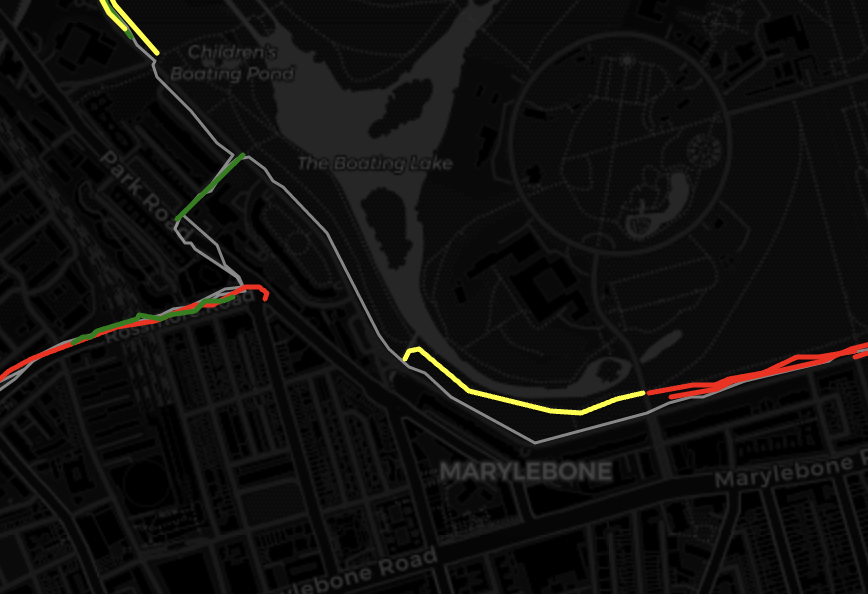

### Filtering the dataset

In [25]:
useful_columns = ['id','distance_km','elapsed_time_min','start_date','start_time','average_speed','max_speed']
output_df = strava_df[useful_columns]
output_df = output_df.rename(columns={'id': 'activity_id'})
output_df

,activity_id,distance_km,elapsed_time_min,start_date,start_time,average_speed,max_speed
0,9149015574,6.6570,40.916667,2023-05-27,11:01:40,2.757,5.448
1,9126742532,6.6517,40.566667,2023-05-23,18:46:44,2.754,5.758
2,9115333522,6.6445,45.616667,2023-05-21,19:02:24,2.466,5.162
3,9101137827,6.7537,47.900000,2023-05-19,16:33:02,2.405,4.468


### Exporting the cleaned and filtered data

In [27]:
output_df.to_csv('strava_api_clean.csv', index=False)

**NOTE:** Here I omitted to include the route data since I later found a much better source of this in .gpx files associated to each activity downloaded directly from strava.